  Author: Ankit Kariryaa, University of Bremen
  
  Modified by Beihui Hu


#*************************************************************************************************************

Copyright (c) 2020, Ankit Kariryaa

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.s

#*************************************************************************************************************


### Overview 

The code was written by Ankit Kariryaa (Kariryaa AT uni-bremen DOT de) in 2018 (see https://doi.org/10.5281/zenodo.3978185), and some modifications were made by Beihui Hu in 2023.

Start by labeling a part of the satellite images with the lakes and storing the labels in shapefiles. The areas that are labeled are denoted by the 'training area' and actual lakes in that area are denoted by the 'training polygons'.

- First, we read the training area and the training polygons from two separate shapefiles. Then we determine the training area for each training polygon. 
- Next, we read the raw satellite images (NDWI channel), and extract training image that overlap with a training area from each satellite image. The part of the NDWI image that overlap with the training area and the corresponding label are then written to separate files.
- Then, we classify the areas and corresponding polygons into different types .

Here, the term training area and training polygon represent all available input data, which can then be separated into training, validation, and test sets in the next notebook(s).

In [1]:
import geopandas as gps
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.mask
import rasterio.warp             # Reproject raster samples
import rasterio.merge
from rasterio.transform import rowcol
from rasterio import features
import fiona                     # I/O vector data (shape, geojson, ...)
import pyproj                    # Change coordinate reference system
from osgeo import gdal
import pandas as pd
import shapely
from shapely.geometry import box, Point
import json

import numpy as np               # numerical array manipulation
import time
import os
from PIL import Image
import PIL.ImageDraw
from core.visualize import display_images

import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from multiprocessing import Pool

In [3]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/Preprocessing.py)
# Please provide required info in the file before continuing with this notebook. 
# hbh: in this scene,a new config named Preprocessing_within is created to distinguish from the original
from config import Preprocessing   
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import Preprocessing
config = Preprocessing.Configuration()

In [4]:
#hbh: check whether the output dir(must be present) of each type is empty
for i in range(0,config.type_num):
    path_to_write=os.path.join(config.training_base_dir,'output\\output'+str(i))
    assert os.path.exists(path_to_write)
    if not len(os.listdir(path_to_write))==0:
         print('Warning: path_to_write{} is not empty! The old files in the directory may not be overwritten!!'.format(i))

In [6]:
#Read the training area 、 training polygons
# trainingArea = gps.read_file(r"G:\GaduationProj\U-Net_3\SampleAnnotations\area193")
trainingArea = gps.read_file(os.path.join(config.training_base_dir, config.training_area_fn))
trainingPolygon = gps.read_file(os.path.join(config.training_base_dir, config.training_polygon_fn))
print(trainingPolygon.shape,trainingArea.shape)# area:id, geomerry;   polygon:id, geometry 
trainingPolygon
trainingArea
print(f'Read a total of {trainingPolygon.shape[0]} object polygons and {trainingArea.shape[0]} training areas.')
print(f'Polygons will be assigned to training areas in the next steps.')

(72274, 2) (250, 3)


,CLASS_NAME,geometry
0,Lake,"POLYGON ((43.99185 26.42376, 43.99167 26.42376..."
1,LowLake,"POLYGON ((43.99742 26.41909, 43.99715 26.41909..."
2,LowLake,"POLYGON ((43.99769 26.41900, 43.99760 26.41900..."
3,LowLake,"POLYGON ((43.99760 26.41873, 43.99751 26.41873..."
4,LowLake,"POLYGON ((44.00074 26.41873, 44.00056 26.41873..."
...,...,...
72269,Lake,"POLYGON ((-120.27795 68.63686, -120.27894 68.6..."
72270,Lake,"POLYGON ((-120.30508 68.63623, -120.30580 68.6..."
72271,Lake,"POLYGON ((-120.22153 68.63524, -120.22171 68.6..."
72272,Lake,"POLYGON ((-120.09451 68.63497, -120.09676 68.6..."


,id,type,geometry
0,8038,0,"POLYGON Z ((14.99528 49.16237 0.00000, 15.2182..."
1,8043,0,"POLYGON Z ((16.56186 44.99800 0.00000, 16.9501..."
2,8069,1,"POLYGON Z ((19.65285 40.68668 0.00000, 19.6528..."
3,8074,1,"POLYGON Z ((19.91069 45.33624 0.00000, 19.9106..."
4,8103,0,"POLYGON Z ((21.99000 44.19058 0.00000, 22.2428..."
...,...,...,...
245,7889,0,"POLYGON Z ((0.16839 41.75588 0.00000, 0.46678 ..."
246,7900,3,"POLYGON Z ((1.69426 42.84020 0.00000, 1.99000 ..."
247,7906,2,"POLYGON Z ((1.38403 48.37467 0.00000, 1.38403 ..."
248,7993,0,"POLYGON Z ((11.81610 44.58577 0.00000, 11.8161..."


Read a total of 72274 object polygons and 250 training areas.
Polygons will be assigned to training areas in the next steps.


In [10]:
# Check if the training areas and the training polygons have the same crs     
if trainingArea.crs  != trainingPolygon.crs:
    print('Training area CRS does not match training_polygon CRS')
    targetCRS = trainingPolygon.crs #Areas are less in number so conversion should be faster
    trainingArea = trainingArea.to_crs(targetCRS)
print(trainingPolygon.crs)
print(trainingArea.crs)
assert trainingPolygon.crs == trainingArea.crs

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [11]:
# Assign serial IDs to training areas    
trainingArea['id'] = range(trainingArea.shape[0])
trainingArea#print(trainingArea.shape)  #area:   id,Type,geometry 

,Shape_Leng,Shape_Area,id,type,geometry
0,0.0,0.0,0,0,"POLYGON Z ((123.40194 56.78484 0.00000, 123.80..."
1,0.0,0.0,1,2,"POLYGON Z ((124.03376 50.54993 0.00000, 124.33..."
2,0.0,0.0,2,1,"POLYGON Z ((128.05269 51.16349 0.00000, 128.05..."
3,0.0,0.0,3,0,"POLYGON Z ((129.01073 58.22204 0.00000, 129.22..."
4,0.0,0.0,4,1,"POLYGON Z ((132.58420 54.18540 0.00000, 132.94..."
5,0.0,0.0,5,1,"POLYGON Z ((136.68898 53.76106 0.00000, 136.83..."
6,0.0,0.0,6,1,"POLYGON Z ((137.24040 50.28864 0.00000, 137.24..."
7,0.0,0.0,7,1,"POLYGON Z ((138.48040 59.78158 0.00000, 138.48..."
8,0.0,0.0,8,0,"POLYGON Z ((141.68997 52.40217 0.00000, 141.93..."
9,0.0,0.0,9,1,"POLYGON Z ((147.59645 59.64643 0.00000, 147.59..."


In [12]:
# As input we received two shapefile, first one contains the training areas/rectangles and other contains the polygon of lakes/objects in those training areas
# The first task is to determine the parent training area for each polygon.

def dividePolygonsInTrainingAreas(trainingPolygon, trainingArea):
    '''Assign annotated ploygons in to the training areas.'''
    # For efficiency, assigned polygons are removed from the list, we make a copy here. 
    cpTrainingPolygon = trainingPolygon.copy()
    splitPolygons = {}
    for i in tqdm(trainingArea.index):
        spTemp = [] 
        allocated = []
        print("area's index:",i)
        for j in cpTrainingPolygon.index:
            if cpTrainingPolygon.loc[j]['geometry'].within(trainingArea.loc[i]['geometry']):
                spTemp.append(cpTrainingPolygon.loc[j])
                allocated.append(j)           
            # Order of bounds: minx miny maxx maxy
        #print(spTemp)
        splitPolygons[trainingArea.loc[i]['id']] = {'polygons':spTemp, 'bounds':list(trainingArea.bounds.loc[i]),'type':trainingArea.loc[i]['type']}
        cpTrainingPolygon = cpTrainingPolygon.drop(allocated)#assigned polygons are removed from the list
    return splitPolygons

# areasWithPolygons contains the object polygons for each area!
areasWithPolygons = dividePolygonsInTrainingAreas(trainingPolygon, trainingArea)
print(f'Assigned training polygons in {len(areasWithPolygons)} training areas')

  0%|          | 0/35 [00:00<?, ?it/s]

area's index: 0
area's index: 1
area's index: 2
area's index: 3
area's index: 4
area's index: 5
area's index: 6
area's index: 7
area's index: 8
area's index: 9
area's index: 10
area's index: 11
area's index: 12
area's index: 13
area's index: 14
area's index: 15
area's index: 16
area's index: 17
area's index: 18
area's index: 19
area's index: 20
area's index: 21
area's index: 22
area's index: 23
area's index: 24
area's index: 25
area's index: 26
area's index: 27
area's index: 28
area's index: 29
area's index: 30
area's index: 31
area's index: 32
area's index: 33
area's index: 34
Assigned training polygons in 35 training areas


In [13]:
### Read the raw input images
def readInputImages(imageBaseDir, rawImageFileType, rawNdwiImagePrefix, rawBandsImagePrefix):
    """
    Reads all images with prefix ndvi_image_prefix and image_file_type datatype in the image_base_dir directory.
    """  
    ndwiImageFn = []
    for root, dirs, files in os.walk(imageBaseDir):
        for file in files:
            if file.endswith(rawImageFileType) and file.startswith(rawNdwiImagePrefix):
                ndwiImageFn.append(os.path.join(root, file))
    bandsImageFn = [fn.replace(rawNdwiImagePrefix, rawBandsImagePrefix) for fn in ndwiImageFn]
    inputImages = list(zip(ndwiImageFn,bandsImageFn))
    return inputImages

inputImages = readInputImages(config.raw_image_base_dir, config.raw_image_file_type, config.raw_NDWI_image_prefix, config.raw_bands_image_prefix)
print(f'Found a total of {len(inputImages)} pair of raw image(s) to process!')

Found a total of 250 pair of raw image(s) to process!


In [14]:
# For each raw satellite image, determine if it overlaps with a training area. 
# If a overlap if found, then extract + write the overlapping part of the raw image, create + write an image from training polygons.

def writeExtractedImageAndAnnotation(img, sm, profile, polygonsInAreaDf,  writePath, imagesFilename, annotationFilename, bands, writeCounter):
    """Write the part of raw image that overlaps with a training area into a separate image file. 
    Use rowColPolygons to create and write annotation image from polygons in the training area.
    """
    try:
        for band, imFn in zip(bands, imagesFilename):
            # Rasterio reads file channel first, so the sm[0] has the shape [1 or ch_count, x,y]
            # If raster has multiple channels, then bands will be [0, 1, ...] otherwise simply [0]
            dt = sm[0][band].astype(profile['dtype'])
            with rasterio.open(os.path.join(writePath, imFn+'_{}.png'.format(writeCounter)), 'w', **profile) as dst:
                dst.write(dt, 1) 
#                 print('write '+ imFn+'_{}.png'.format(writeCounter) +' image\n')

        if annotationFilename:
            annotation_filepath = os.path.join(writePath,annotationFilename+'_{}.png'.format(writeCounter))
            polygons = []
            for i in polygonsInAreaDf.index:
                gm = polygonsInAreaDf.loc[i]['geometry']
                polygons.append(gm)
                
            with rasterio.open(annotation_filepath, 'w+', **profile) as out:
                out_arr = out.read(1)
                burned = features.rasterize(polygons, fill=0, default_value=1,out=out_arr, transform=out.transform)
                out.write_band(1, burned)
        return(writeCounter+1)
    
    except Exception as e:
        print(e)
        print("Something nasty happened, could not write the annotation or the mask file!======\n\n\n")
        return writeCounter
        
def findOverlap(img, areasWithPolygons, writePath, imageFilename, annotationFilename, bands, writeCounter):
    """Finds overlap of image with a training area.
    Use writeExtractedImageAndAnnotation() to write the overlapping training area and corresponding polygons in separate image files.
    """
    overlappedAreas = set()
    
    for areaID, areaInfo in areasWithPolygons.items():
        #Convert the polygons in the area   in a dataframe and get the bounds of the area. 
        polygonsInAreaDf = gps.GeoDataFrame(areaInfo['polygons'])
        bboxArea = box(*areaInfo['bounds'])#area bounds
        bboxImg = box(*img.bounds)#image bounds
        
        #Extract the window if area is in the image
        #hbh: if an area may overlap with multiple images, use intersect() rather than within()
        #if(bboxArea.within(intersect)):
        if(bboxArea.within(bboxImg)):
            profile = img.profile  
            sm = rasterio.mask.mask(img, [bboxArea], all_touched=True, crop=True )
            profile['height'] = sm[0].shape[1]
            profile['width'] = sm[0].shape[2]
            profile['transform'] = sm[1]
            # That's a problem with rasterio, if the height and the width are less then 256 it throws: ValueError: blockysize exceeds raster height 
            # So set the blockxsize and blockysize to prevent this problem
            profile['blockxsize'] = 32
            profile['blockysize'] = 32
            profile['count'] = 1
            #hbh:band[ndwi] is range from[-100,100]
            profile['dtype'] = rasterio.float32
            writeCounter = writeExtractedImageAndAnnotation(img, sm, profile, polygonsInAreaDf, writePath, imageFilename, annotationFilename,  bands, writeCounter)
            overlappedAreas.add(areaID)
    return(writeCounter, overlappedAreas)


def extractAreasThatOverlapWithTrainingData(inputImages, areasWithPolygons, writePath, NdwiFilename,BandsFilename, annotationFilename, writeCounter):
    """Iterates over raw NDWI images and using findOverlap() extract areas that overlap with training data. 
    The overlapping areas in raw images are written in a separate file, and annotation file are created from polygons in the overlapping areas.
    """
    if not os.path.exists(writePath):
        os.makedirs(writePath)
        
    overlappedAreas = set()
    for imgs in tqdm(inputImages):
        ndwiImg = rasterio.open(imgs[0])
#         print(ndwiImg.shape)
        bandsImg = rasterio.open(imgs[1])
        ncNDWI,imOverlappedAreasNDWI = findOverlap(ndwiImg, areasWithPolygons, writePath=writePath, imageFilename=[NdwiFilename], annotationFilename=annotationFilename, bands=config.bands0, writeCounter=writeCounter)
        ncBands,imOverlapppedAreasBands = findOverlap(bandsImg, areasWithPolygons, writePath=writePath, imageFilename=BandsFilename, annotationFilename='', bands=config.bands1, writeCounter=writeCounter )
        if ncNDWI == ncBands:
            writeCounter = ncNDWI
        else: 
            print('Couldnt create mask!!!')
            print(ncNDWI)
            print(ncBands)
            break;
        overlappedAreas.update(imOverlappedAreasNDWI)
    
    allAreas = set(areasWithPolygons.keys())
    if allAreas.difference(overlappedAreas):
        print(f'Warning: Could not find a raw image correspoinding to {allAreas.difference(overlappedAreas)} areas. Make sure that you have provided the correct paths!')
    return writeCounter

In [15]:
writeCounter=465
for key,value in zip(areasWithPolygons.keys(),areasWithPolygons.values()):
    newdict={}
    path_to_write=os.path.join(config.training_base_dir,'output\output'+str(value['type']))
    newdict[key] = {'polygons':value['polygons'], 'bounds':value['bounds']}
    writeCounter=extractAreasThatOverlapWithTrainingData(inputImages,newdict, path_to_write, config.extracted_NDWI_filename,config.extracted_bands_filename, config.extracted_annotation_filename, writeCounter)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [33]:
print(writeCounter)

465


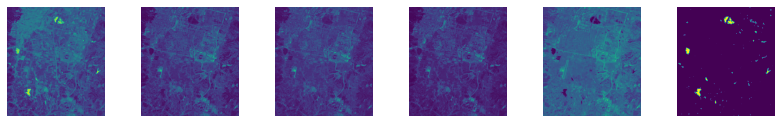

In [34]:
# Display extracted image 
sampleImage = '_7.png'
# path_to_write=os.path.join(config.training_base_dir,'output\output4')
path_to_write=os.path.join(config.training_base_dir,'output\output2' )
fn = os.path.join(path_to_write, config.extracted_NDWI_filename + sampleImage)
NDWI_img = Image.open(fn)
read_NDWI_img = np.array(NDWI_img)

redBands = os.path.join(path_to_write, 'red'+ sampleImage)
red_img = Image.open(redBands)
read_red_img = np.array(red_img)

greenBands = os.path.join(path_to_write, 'green'+ sampleImage)
green_img = Image.open(greenBands)
read_green_img = np.array(green_img)

blueBands = os.path.join(path_to_write, 'blue'+ sampleImage)
blue_img = Image.open(blueBands)
read_blue_img = np.array(blue_img)

swirBands = os.path.join(path_to_write, 'swir'+ sampleImage)
swir_img = Image.open(swirBands)
read_swir_img = np.array(swir_img)
# print(read_NDWI_img.shape)
# print(read_Bands_img.shape)
annotation_im = Image.open(fn.replace(config.extracted_NDWI_filename ,config.extracted_annotation_filename))
read_annotation = np.array(annotation_im)
# print(read_annotation.shape)
# print(read_annotation)

all_images = np.array([read_NDWI_img,read_red_img,read_green_img,read_blue_img,read_swir_img, read_annotation])
# print(all_images.shape[1])
display_images(np.expand_dims(np.transpose(all_images, axes=(1,2,0)), axis=0))